In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import optuna
import logging
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

%matplotlib inline

### 1. Фиксация генератора случайных чисел

In [2]:
seed = 1920  # 1982 1920 1910 2000 1902
np.random.seed(seed)
random.seed(seed)

### 2. Загрузка датасета

In [3]:
df = pd.read_excel("C:\Datasets/10_fire_dataset_bin.xlsx")
df.shape

(8166, 22)

In [4]:
df.head()

,Unnamed: 0,area,lon,lat,Dist_str,Dist_railw,Dist_car,T,Po,P,...,DD,Ff,N,WW,Cl,Nh,H,Cm,VV,Td
0,2017-09-24 10:00:00,0,0.0,0.0,0.0,0.0,0.0,9.4,761.9,774.8,...,"Ветер, дующий с востока",2,100%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,600-1000,"Высококучевые просвечивающие, расположенные на...",10.0,4.3
1,2017-09-24 13:00:00,0,0.0,0.0,0.0,0.0,0.0,11.7,762.4,775.2,...,"Ветер, дующий с северо-северо-востока",3,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,3.1
2,2017-09-24 16:00:00,0,0.0,0.0,0.0,0.0,0.0,11.6,762.7,775.6,...,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3
3,2017-09-24 19:00:00,0,0.0,0.0,0.0,0.0,0.0,7.7,763.3,776.4,...,"Ветер, дующий с северо-востока",2,70 – 80%.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,1.2
4,2017-09-24 22:00:00,0,0.0,0.0,0.0,0.0,0.0,6.1,763.6,773.7,...,"Ветер, дующий с севера",1,Облаков нет.,NaN,"Кучево-дождевые лысые с кучевыми, слоисто-куче...",70 – 80%.,600-1000,"Высококучевых, высокослоистых или слоисто-дожд...",10.0,2.3


In [5]:
df.describe()

,area,lon,lat,Dist_str,Dist_railw,Dist_car,T,Po,P,Pa,U,Ff,VV,Td
count,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000
mean,0.051678,2.611662,2.745962,1902.796763,869.270501,30.162300,5.469949,750.730541,763.665711,0.011254,69.344722,1.891134,9.440546,-0.732648
std,0.221389,11.190458,11.764578,10783.521134,4721.993706,178.232637,11.845542,7.528750,7.882456,0.974373,20.822901,1.025589,2.467542,9.151439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23.800000,725.600000,738.600000,-22.000000,12.000000,0.000000,0.200000,-26.200000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,745.900000,758.500000,-0.500000,54.000000,1.000000,10.000000,-7.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.800000,750.800000,763.600000,0.000000,74.000000,2.000000,10.000000,-0.800000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,755.400000,768.700000,0.500000,87.000000,3.000000,10.000000,6.600000
max,1.000000,52.419154,54.624496,139339.388668,53919.346006,3065.928510,36.100000,777.000000,790.900000,25.200000,100.000000,7.000000,50.000000,20.200000


In [6]:
df.describe(include='object')

,DD,N,WW,Cl,Nh,H,Cm
count,8166,8166,2335,8166,8166,8166,8166
unique,17,10,79,10,9,6,8
top,"Ветер, дующий с запада",100%.,Состояние неба в общем не изменилось.,"Слоисто-кучевых, слоистых, кучевых или кучево-...",100%.,600-1000,"Высококучевые просвечивающие, расположенные на..."
freq,1511,3395,698,3126,1896,4066,3863


Проверка сбалансированности классов

In [7]:
count_0 = np.bincount(df['area'])[0]
count_1 = np.bincount(df['area'])[1]

print(f"Число элементов, равных 0: {count_0}")
print(f"Число элементов, равных 1: {count_1}")

Число элементов, равных 0: 7744
Число элементов, равных 1: 422


Редактирование столбца "Unnamed: 0" - остается только month (месяц), тип данных заменяется на object

In [8]:
df['Unnamed: 0'] = df['Unnamed: 0'].dt.month
df.rename({'Unnamed: 0': 'Month'}, axis=1, inplace=True)
df.head()
df['Month'] = df['Month'].astype('object')

Распределение числа пожаров по месяцам

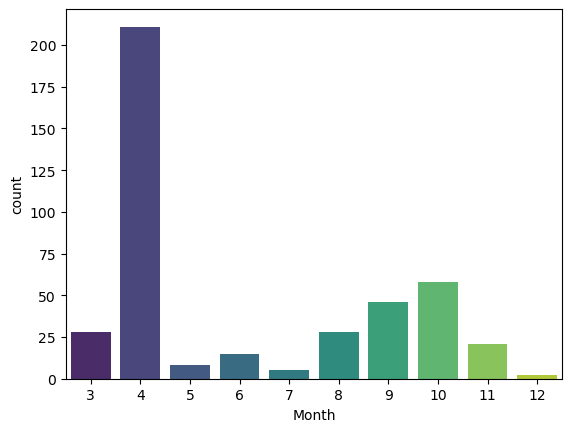

Число пожаров по месяцам (всего пожаров - 422):


,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,28,211,8,15,5,28,46,58,21,2


In [9]:
df_0 = df[df['area']==0]
df_1 = df[df['area']==1]
sns.countplot(data=df_1, x="Month", palette='viridis')
plt.show()

count = [len(df_1[df_1['Month']==k]) for k in range(1, 13)]
df_count = pd.DataFrame([count], columns=range(1, 13))
print(f'Число пожаров по месяцам (всего пожаров - {len(df_1)}):')
df_count

### 3. Feature engineering

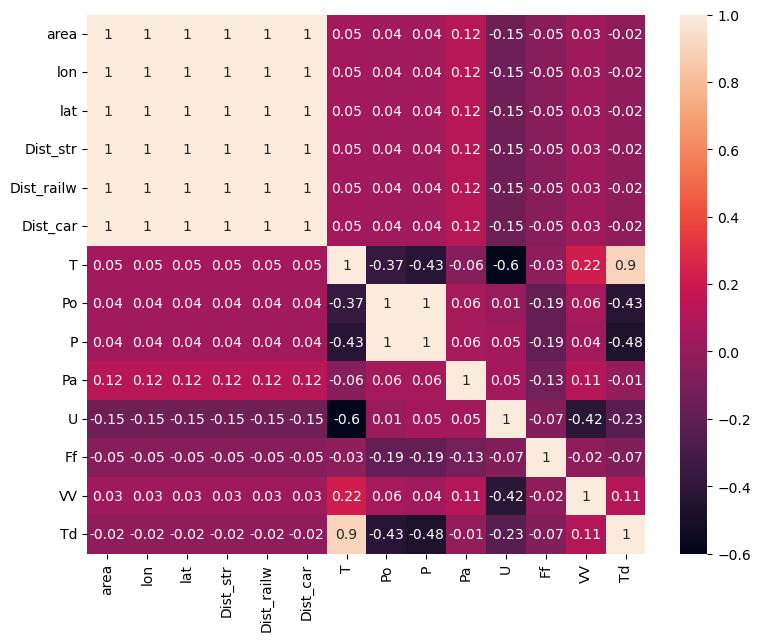

In [10]:
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr(method='spearman').round(2), annot=True)
plt.show()

Удаление коррелированных признаков

In [11]:
df = df.drop(columns=['lon', 'lat', 'Dist_railw', 'Dist_str', 'Dist_car', 'Po', 'Td'])

Удаление части категориальных признаков, кодирование оставшихся

In [12]:
df = df.drop(['Cl', 'Nh', 'H', 'Cm'], axis=1)
df = pd.get_dummies(data=df, prefix='cat_', drop_first=True)
df.shape

(8166, 121)

Коэф. корреляции признаков с целевой переменной area

In [13]:
df.corrwith(df.area).sort_values(ascending=False).round(3) # ascending=False - это сортировка по убыванию

area                                          1.000
cat__4                                        0.296
cat__Облаков нет.                             0.126
cat__Ветер, дующий с северо-востока           0.121
cat__Ветер, дующий с севера                   0.083
                                              ...  
cat__Состояние неба в общем не изменилось.   -0.059
cat__2                                       -0.067
cat__12                                      -0.072
cat__100%.                                   -0.102
U                                            -0.149
Length: 121, dtype: float64

Удаление признаков с низким коэф. корреляции

In [14]:
coeff_cor_min = 0.025

features_low = [i for i in df.columns if df.corrwith(df.area).abs()[i] < coeff_cor_min]
print("Удаляемые признаки:")
df[features_low].corrwith(df.area).sort_values(ascending=False).round(3)

Удаляемые признаки:


cat__Ветер, дующий с востоко-северо-востока                                         0.018
cat__Штиль, безветрие                                                               0.018
cat__40%.                                                                           0.017
cat__70 – 80%.                                                                      0.015
cat__Снег непрерывный умеренный в срок наблюдения.                                 -0.000
                                                                                    ...  
cat__Небо не видно из-за тумана и/или других метеорологических явлений.            -0.018
cat__Ливневый(ые) дождь(и) слабый(ые) в срок наблюдения или за последний час.      -0.019
cat__Слабый или умеренный поземок в целом низкий (ниже уровня глаз наблюдателя).   -0.021
cat__Дождь незамерзающий непрерывный слабый в срок наблюдения.                     -0.022
cat__Ливневый(ые) дождь(и).                                                        -0.023
Length: 88

Оставшиеся признаки для обучения моделей

In [15]:
df = df.drop(features_low, axis=1)
X = df.copy()
y = X.pop("area")
X = X.values
y = y.values

print('Оставшиеся признаки:')
df.corrwith(df.area).sort_values(ascending=False).round(3) # ascending=False - это сортировка по убыванию

Оставшиеся признаки:


area                                          1.000
cat__4                                        0.296
cat__Облаков нет.                             0.126
cat__Ветер, дующий с северо-востока           0.121
cat__Ветер, дующий с севера                   0.083
cat__Ветер, дующий с северо-северо-востока    0.077
Pa                                            0.072
cat__60%.                                     0.053
cat__Ветер, дующий с северо-северо-запада     0.051
T                                             0.046
VV                                            0.035
cat__9                                        0.029
P                                             0.027
cat__10                                       0.026
cat__Дымка.                                  -0.027
cat__Ветер, дующий с западо-северо-запада    -0.028
cat__6                                       -0.028
cat__Ветер, дующий с юго-востока             -0.029
cat__90  или более, но не 100%               -0.031
cat__11     

### 4. Разбиение датасета на train и test, масштабирование признаков

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=seed)
sc = StandardScaler() # RobustScaler() StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

count_0 = np.bincount(y_train)[0]
count_1 = np.bincount(y_train)[1]

print(f"Число элементов, равных 0: {count_0}")
print(f"Число элементов, равных 1: {count_1}")

Число элементов, равных 0: 5421
Число элементов, равных 1: 295


### 5. Параметры OPTUNA, обучение моделей с кросс-валидацией и балансировкой классов

In [17]:
# Установка уровня журналирования для Optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Кросс-валидация с балансировкой классов
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
balancer = RandomOverSampler(random_state=seed)
# balancer = SMOTE(random_state = seed)
# balancer = RandomUnderSampler(random_state = seed)

# Список классификаторов для перебора
classifiers = [CatBoostClassifier, LGBMClassifier, XGBClassifier]

# Функция для оптимизации гиперпараметров с помощью Optuna
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['CatBoostClassifier', 'LGBMClassifier', 'XGBClassifier'])

    if classifier_name == 'CatBoostClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = CatBoostClassifier(learning_rate=learning_rate, max_depth=max_depth, min_data_in_leaf=min_data_in_leaf, 
                                        n_estimators=n_estimators, random_state=seed, silent=True)

    elif classifier_name == 'LGBMClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_samples = trial.suggest_int('min_child_samples', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = LGBMClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_samples=min_child_samples, 
                                    n_estimators=n_estimators, random_state=seed, silent=True)

    elif classifier_name == 'XGBClassifier':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 3, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
        classifier = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, 
                                   n_estimators=n_estimators, random_state=seed)
        
    # Кросс-валидация
    roc_auc_scores = []
    for train_idx, val_idx in kf.split(X_train_std, y_train):
        X_train_fold, y_train_fold = X_train_std[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train_std[val_idx], y_train[val_idx]
        
        # Применение бансировки классов только к обучающим фолдам
        X_train_fold_resampled, y_train_fold_resampled = balancer.fit_resample(X_train_fold, y_train_fold)
        
        # Обучение модели
        classifier.fit(X_train_fold_resampled, y_train_fold_resampled)
        
        # Оценка модели на валидационном фолде
        y_pred_fold = classifier.predict(X_val_fold)
        roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_fold))
    
    # Усредненная оценка ROC AUC по фолдам
    roc_auc_mean = np.mean(roc_auc_scores)
    return roc_auc_mean

# Создание и оптимизация study с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод наилучшего значения метрики после кросс-валидации
best_score = study.best_value
print("Наилучшее значение метрики (ROC AUC) после кросс-валидации:", best_score)

# Лучшая модель
best_params = study.best_params
classifier_name = best_params['classifier']
if classifier_name == 'CatBoostClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    min_data_in_leaf = best_params['min_data_in_leaf']
    n_estimators = best_params['n_estimators']
    classifier = CatBoostClassifier(learning_rate=learning_rate, max_depth=max_depth, min_data_in_leaf=min_data_in_leaf, 
                                    n_estimators=n_estimators, random_state=seed, silent=True)

elif classifier_name == 'LGBMClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    min_child_samples = best_params['min_child_samples']
    n_estimators = best_params['n_estimators']
    classifier = LGBMClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_samples=min_child_samples, 
                                n_estimators=n_estimators, random_state=seed, silent=True)

elif classifier_name == 'XGBClassifier':
    learning_rate = best_params['learning_rate']
    max_depth = best_params['max_depth']
    min_child_weight = best_params['min_child_weight']
    n_estimators = best_params['n_estimators']
    classifier = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, 
                               n_estimators=n_estimators, random_state=seed)

# Обучение лучшей модели на полном тренировочном наборе данных
X_train_resampled, y_train_resampled = balancer.fit_resample(X_train_std, y_train)
classifier.fit(X_train_resampled, y_train_resampled)
y_pred = classifier.predict(X_test_std)
y_pred_train = classifier.predict(X_train_std)

# Вывод значения метрики для лучшей модели после обучения
roc_auc_test = roc_auc_score(y_test, y_pred)

print("Значение метрики (ROC AUC) после обучения на всем тренировочном наборе данных:", roc_auc_test)
print("Лучший классификатор:", classifier_name)
print("Лучшие параметры:", best_params)
print(f'Число верно классифицированных случаев: {(y_test == y_pred).sum()} из {X_test_std.shape[0]}')

Лучший классификатор: LGBMClassifier
Лучшие параметры: {'classifier': 'LGBMClassifier', 'learning_rate': 0.09423573592689553, 'max_depth': 8, 'min_child_samples': 6, 'n_estimators': 1000}
Число верно классифицированных случаев: 2406 из 2450


### 6. Метрики

In [18]:
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train).round(3)}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred).round(3)}\n')
print(f'Precision Train: {precision_score(y_train, y_pred_train).round(3)}')
print(f'Precision Test: {precision_score(y_test, y_pred).round(3)}\n')
print(f'Recall Train: {recall_score(y_train, y_pred_train).round(3)}')
print(f'Recall Test: {recall_score(y_test, y_pred).round(3)}\n')
print(f'F1 Train: {f1_score(y_train, y_pred_train).round(3)}')
print(f'F1 Test: {f1_score(y_test, y_pred).round(3)}\n')

Accuracy Train: 0.986
Accuracy Test: 0.982

Precision Train: 0.787
Precision Test: 0.803

Recall Train: 1.0
Recall Test: 0.866

F1 Train: 0.881
F1 Test: 0.833



### 7. Матрица ошибок (Confusion Matrix)

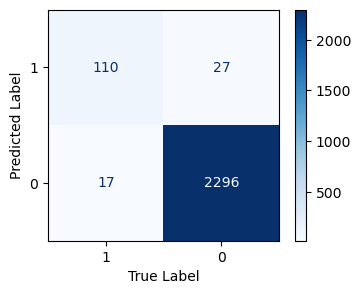

In [19]:
cm = confusion_matrix(y_test, y_pred)
cm_flipped = cm.copy()
cm_flipped[0, 0], cm_flipped[1, 1] = cm[1, 1], cm[0, 0]
cm_display = ConfusionMatrixDisplay(cm_flipped, display_labels=classifier.classes_)
fig, ax = plt.subplots(figsize=(4, 3))
cm_display.plot(ax=ax, cmap='Blues')
# Получение текущих значений меток осей
tick_labels_x = ax.get_xticklabels()
tick_values_x = ax.get_xticks()
tick_labels_y = ax.get_yticklabels()
tick_values_y = ax.get_yticks()
# Изменение меток и подписей осей
ax.set_xticks(tick_values_x)
ax.set_xticklabels('1' if label.get_text() == '0' else '0' for label in tick_labels_x)
ax.set_yticks(tick_values_y)
ax.set_yticklabels('1' if label.get_text() == '0' else '0' for label in tick_labels_y)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


### 8. График ROC-AUC

ROC-AUC Train: 0.99709
ROC-AUC Test: 0.9469


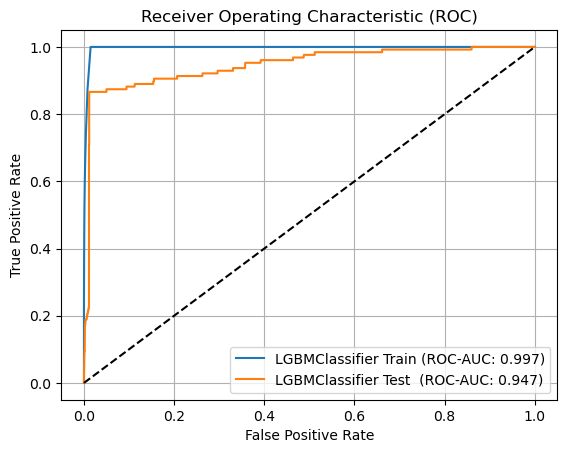

In [21]:
y_pred_train_score = classifier.predict_proba(X_train_std)
y_pred_score = classifier.predict_proba(X_test_std)
roc_auc_train = roc_auc_score(y_train, y_pred_train_score[:,1])
roc_auc_test = roc_auc_score(y_test, y_pred_score[:,1])

print(f'ROC-AUC Train: {roc_auc_train.round(5)}')
print(f'ROC-AUC Test: {roc_auc_test.round(5)}')

# Создание общей области для графиков
fig, ax = plt.subplots()

# ROC-кривая для обучающей выборки
y_pred_proba_train = classifier.predict_proba(X_train_std)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
roc_display_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, estimator_name=f"{classifier_name} Train (ROC-AUC: {roc_auc_train:.3f})")
roc_display_train.plot(ax=ax)

# ROC-кривая для тестовой выборки
y_pred_proba_test = classifier.predict_proba(X_test_std)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_display_test = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, estimator_name=f"{classifier_name} Test  (ROC-AUC: {roc_auc_test:.3f})")
roc_display_test.plot(ax=ax)

ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc='lower right')  # Перемещение легенды в правый нижний угол
plt.plot([0, 1], [0, 1], "k--")
ax.grid(True)  # Добавление линий сетки
plt.show()